# Setup

In [1]:
import fastbook
from fastbook import *
import torch
#print(torch.cuda.is_available())
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from PIL import Image
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
import random
import torchvision
import wandb
import torch.nn.functional as F
from torchinfo import summary

c:\Users\zeusg\Envs\real-fast\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [25]:

wandb.init(project="skeletons")
config = wandb.config
config.batch_size = 10
config.epochs = 10
config.z_dim = 10
config.og_img_size = [config.batch_size, config.z_dim , 4, 4]
config.dimensions = (config.batch_size, 1, 512, 512)
config.noise_vec = [config.batch_size, config.z_dim]
config.log_every = 1
config.device = "cuda"

config.progan_seq = [4, 8, 16, 32, 64, 128, 256, 512]
config.prodisc_seq = config.progan_seq[::-1]
config.max_num_blocks = len(config.progan_seq)

config.init_alpha =.5
config.inc_alpha = .1


config.disc_lr=0.0001
config.gen_lr=0.0001


In [3]:
#path = Path.BASE_PATH = r".\all_temp"
config.file_path = r".\all"
path = Path.BASE_PATH = config.file_path

music = DataBlock(blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items= get_image_files,
        splitter = RandomSplitter(seed = 23),
        get_y = using_attr(RegexLabeller(r'^([^.]+)'), 'name'))
dls = music.dataloaders(path, bs=config.batch_size)
#music.summary(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


# Utils

In [4]:
def view_gen_image(y):
    y = y.clone()
    image = y[0,0].detach().to("cpu").numpy() 
    plt.figure(figsize=(40,10))
    plt.imshow(image)

In [43]:
def generate_image(gen, name):
    x = get_noise(num_images, config.z_dim, device=config.device).to("cuda")
    now = datetime.now()
    current_time = now.strftime("%y%d%H%M%S")
    out_path = os.path.join("./", current_time)
    y = gen(x)
    y = y[0,0].detach().to("cpu").numpy()
    
    plt.figure(figsize=(8,8))
    plt.imshow(y, cmap = "gray")
    plt.savefig(out_path+"/Generated"+str(name)+".png")
    plt.show()
    np.save(out_path+"/Generated"+str(name), y)


In [12]:
class DownDownDown(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.AvgPool2d(2,2)
        )
    def forward(self, x):
        return self.model(x)

In [13]:
def downsample(n_times, image):
    pool =  DownDownDown()
    for n in range(n_times):
        image = pool(image)
    return image
       

# Models

## Generator

torch.Size([10, 1, 4, 4])
torch.Size([10, 1, 8, 8])
torch.Size([10, 1, 16, 16])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1, 64, 64])
torch.Size([10, 1, 128, 128])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 512, 512])


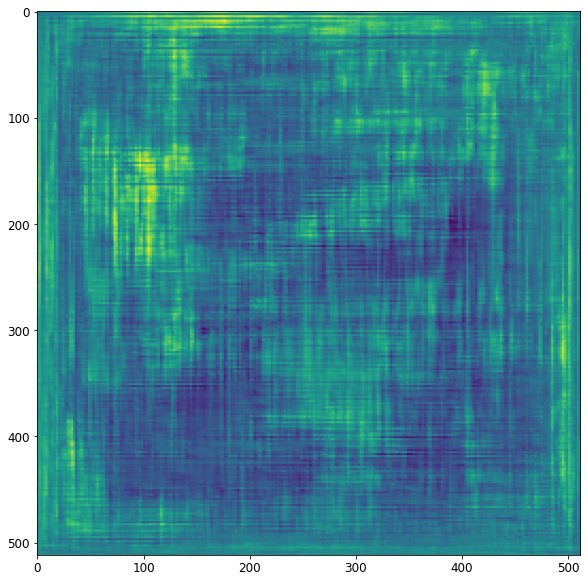

In [7]:
class ProConGan(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleList([ProGanBlock(config.z_dim, 512)])
        self.alpha = config.init_alpha
        self.alpha_increment = config.inc_alpha
        self.toBW =  nn.ModuleList([nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, bias=False).cuda()])
        self.dim_progression = config.progan_seq
        self.model_size = len(self.dim_progression)-1
        self.dim_index = 0

    def add_block(self):
        self.model.append(nn.Upsample(scale_factor=2))
        in_shape = self.dim_progression[self.model_size-(self.dim_index)]
        out_shape =self.dim_progression[max(0,self.model_size-(self.dim_index+1))]
        
        self.model.append(ProGanBlock(in_channels=in_shape, \
            out_channels=out_shape).cuda())

        if len(self.model) == 3:
            self.toBW.append(nn.Conv2d(in_channels=out_shape, out_channels=1, kernel_size=1, stride=1, bias=False).cuda())
        else:
            self.toBW[0] = self.toBW[1]
            self.toBW[1] = nn.Conv2d(in_channels=out_shape, out_channels=1, kernel_size=1, stride=1, bias=False).cuda()
        

        self.reset_alpha()
        self.dim_index += 1
        #Replace to BW

    def increment_alpha(self):
        self.alpha = self.alpha+self.alpha_increment
        self.alpha = min(1, self.alpha)
    
    def reset_alpha(self):
        self.alpha = config.init_alpha

    def get_dim(self):
        return self.dim_progression[self.dim_index]

    def forward(self, x):
        for i, layer in enumerate(self.model):
            if i<len(self.model)-1 or len(self.model) == 1:
                x = layer(x)
                if len(self.model) == 1:
                    #print(x.shape)
                    x = self.toBW[0](x)
            else:
                x = self.toBW[1](self.alpha*layer(x)) + self.toBW[0]((1-self.alpha)*(x))
        return x

class ProGanBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(),
        )
    def forward(self, x):
        x = self.block(x)
        return x
        

def test_progan():
    pro = ProConGan().cuda()
    x = torch.rand(config.og_img_size).cuda()
    pro_architecture = {}
    pro_architecture[-1] = str(pro)
    for i in range(config.max_num_blocks):
        y = pro(x)
        print(y.shape)
        pro.add_block()
        pro.increment_alpha()
        pro_architecture[i] = str(pro)
    view_gen_image(y)
    config.pro_architecture = pro_architecture
test_progan()

In [19]:
class ProConDisc(nn.Module):
    def __init__(self):
        super().__init__()
        #self.model = nn.ModuleList([ProDiscBlock(1, 4), nn.Flatten(), nn.Linear(int(np.prod(og_img_size)/batch_number), 1)])
        self.model = nn.ModuleList([ProDiscBlock(2, 5), 
                                    FinalDiscBlock(2, 1),
                                    FinalDiscBlock(1, 1)
                                   ])
        self.alpha = config.init_alpha
        self.alpha_increment = config.inc_alpha
        self.fromBW =  nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=4, kernel_size=1, stride=1).cuda()])
        self.dim_progression = config.prodisc_seq
        self.dim_index=0
        self.model_size = len(self.dim_progression)-1 

    def add_block(self):
        in_shape = self.dim_progression[self.model_size-(self.dim_index)]
        out_shape =self.dim_progression[max(0,self.model_size-(self.dim_index+1))]

        if len(self.model) == 3:
            self.fromBW.append(nn.Conv2d(in_channels=1, out_channels=out_shape, kernel_size=1, stride=1).cuda())
        else:
            self.fromBW[0] = self.fromBW[1]
            self.fromBW[1] = nn.Conv2d(in_channels=1, out_channels=out_shape, kernel_size=1, stride=1).cuda()

        self.model.insert(0,nn.AvgPool2d(kernel_size=2, stride=2))
        self.model.insert(0,ProDiscBlock(in_shape, out_shape).cuda())
        self.reset_alpha()
        self.dim_index+=1

        

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)
        
    def increment_alpha(self):
        self.alpha = self.alpha+self.alpha_increment
        self.alpha = min(1, self.alpha)
    
    def reset_alpha(self):
        self.alpha = config.init_alpha

    def forward(self, x):
        #model[0] is the CNN layer
        #model[1] is the avg pool layer
        if len(self.model) > 3:
    
            x_1 = self.fromBW[1](x)
            x_1 = self.model[0](x_1)
            x_1 = self.model[1](x_1)

            x_2 = self.model[1](x)
            x_2 = self.fromBW[0](x_2)
            x = self.alpha * x_1 + (1-self.alpha)*x_2
            
        for i, layer in enumerate(self.model):
            if len(self.model) == 3 and i ==0:
                x = self.fromBW[0](x)
                x = self.minibatch_std(x)
            if i>1 or len(self.model) == 3: 
                if i+3 == len(self.model) and len(self.model) !=3:
                    x = self.minibatch_std(x)
                x = layer(x) 
        return x[:,:,0,0]
    
    
class ProDiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            PixelNorm(),
            nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            PixelNorm(),
        )
    def forward(self, x):
        x = self.block(x)
        return x
        
class FinalDiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
        )
    def forward(self, x):
        x = self.block(x)
        return x

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)
    


def test_discgan():
    pro = ProConGan().cuda()
    disc = ProConDisc().cuda()
    x = torch.rand(config.og_img_size).cuda()
    batch_x = dls.valid.one_batch()[0]
    batch_x =downsample(6, batch_x)
    print(disc(batch_x))
    
    for i in range(3):
        print("EPOCH")
        y = pro(x)
        result = disc(y)
        pro.add_block()
        disc.add_block()
        pro.increment_alpha()
    
test_discgan()

TensorImageBW([[0.0809],
        [0.0810],
        [0.0808],
        [0.0808],
        [0.0809],
        [0.0809],
        [0.0810],
        [0.0812],
        [0.0809],
        [0.0809]], device='cuda:0', grad_fn=<AliasBackward0>)
EPOCH
EPOCH
EPOCH


# Loss 

In [28]:
def get_noise(num_images, z_dim, device="cuda"):
    noise = None
    if device == "cuda":
            noise = torch.rand(config.og_img_size , device=device).cuda()
    else:
        noise = torch.rand(config.noise_vec)
    return noise

In [33]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device="cuda"):
    '''
    Returns the loss of the generator
    Params: 
    Gen: Generator Model
    Disc: Discrimiator Model
    Criterion: Loss Function
    num_images: The number of images the generator should produce
    z_dim: The dim of the noise vector
    Device: What device we run it on
    '''
    fake_images = gen(get_noise(num_images, z_dim, device=device))

    fake_images = torch.reshape(fake_images, (config.batch_size, 1, gen.get_dim(), gen.get_dim()))

    fake_images.detach()
    
    real_labels = torch.ones((num_images,1),device=device)
    
    prediction = disc(fake_images)
    gen_loss = criterion(prediction, real_labels)
    return gen_loss

In [36]:
def get_disc_loss(gen, disc, criterion, real_input, num_images, z_dim, device="cuda"):
    '''
    Return Loss of discriminator 
    Params: 
    Gen: Geneartor model
    Disc: Discrimiator Model
    criterion: Loss function
    Real Input: Our data set images
    Num_images: Len(real input)
    z_dim: Dimention of our noise vector
    Return a loss value for 1 batch
    '''

    real_input = downsample((6-disc.dim_index), real_input)
    
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    
    fake_images = torch.reshape(fake_images, (config.batch_size, 1, gen.get_dim(), gen.get_dim()))

    fake_images.detach()
    
    fake_labels = torch.zeros((num_images,1),device=device)
    real_labels = torch.ones((num_images,1),device=device)                                

    fake_loss = criterion(disc(fake_images), fake_labels)
    real_loss = criterion(disc(real_input), real_labels)
    disc_loss = (fake_loss + real_loss)/2
    return disc_loss

# Training

Finished epoch
Alpha: 1
Epoch: 0
3.8405476331710817
2.9695327639579774


FileNotFoundError: [Errno 2] No such file or directory: './2221165207/Generated0.png'

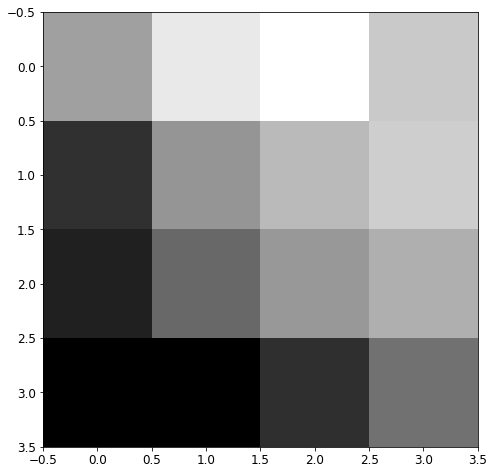

In [44]:
print_layers = False
criterion = nn.MSELoss()

gan = None
disc = None

block_count = 0

gen = ProConGan().to(config.device)
disc = ProConDisc().to(config.device)


gen_opt = torch.optim.Adam(gen.parameters(), lr=config.gen_lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=config.disc_lr)

disc_loss_hist = [] 
gen_loss_hist = []

disc_metric_real = []
disc_metric_fake = []


for epoch in range(config.epochs):
    disc_loss_batch = 0.0
    gen_loss_batch = 0.0
    for batch in dls.train:
        real_images, *_ = batch
        real_images = real_images.to(config.device)
        num_images = len(real_images)

        #Train Generator
        gen_opt.zero_grad()
        
        gen_loss = get_gen_loss(gen, disc, criterion, num_images, config.z_dim, config.device)
        #gen_loss = get_gen_loss_wgan(gen, disc, real_images)
        
        gen_loss_batch+=gen_loss.item()
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        ##Train discriminator
        disc_opt.zero_grad()
        
        disc_loss = get_disc_loss(gen, disc, criterion, real_images, num_images, config.z_dim, config.device)
        #disc_loss = get_disc_loss_wgan(gen, disc, real_images)
        
        disc_loss_batch+=disc_loss.item()
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        

        gen.increment_alpha()
        disc.increment_alpha()


    print("Finished epoch")
    print("Alpha: "+ str(gen.alpha))
    if epoch % 10==0 and epoch !=0 and gen.dim_index !=8 and block_count < max_num_blocks:
        gen.add_block()
        disc.add_block()
        print("adding block")
        block_count += 1


    print("Epoch: " + str(epoch))
    print(disc_loss_batch/config.batch_size)
    print((gen_loss_batch/config.batch_size)) #WHY?

    disc_loss_hist.append(disc_loss_batch/config.batch_size)
    gen_loss_hist.append(gen_loss_batch/config.batch_size)

    if epoch % (config.log_every) == 0: 
        for i in range(1):
            generate_image(gen,epoch)
            reals = downsample((7-disc.dim_index), real_images)
            reals = reals.detach().to("cpu").numpy()[0][0]
            print(reals.shape)
            fake_images = gen(get_noise(num_images, z_dim, device=device))
            #fake_images = torch.reshape(fake_images, dimensions)
            #fake_images.detach()
            print("REAL")
            plt.figure(figsize=(8,8))
            plt.imshow(reals, cmap = "gray")
            plt.show()
            
            fake_images = torch.reshape(fake_images, (config.batch_size, 1, gen.get_dim(), gen.get_dim()))
            fake_images.detach()
            prediction = disc(fake_images)
            print(prediction)
